In [1]:
from amftrack.pipeline.development.high_mag_videos.kymo_class import *
import os
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
%matplotlib widget
%load_ext autoreload
%autoreload 2
from amftrack.pipeline.functions.image_processing.extract_graph import (
    from_sparse_to_graph,
    generate_nx_graph,
    clean_degree_4,
)
import scipy


F:\AMOLF_Projects\amftrack\util\dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


F:/AMOLF_Data/TEMP
This is not a linux system, I am lost


# Welcome to the video analysis pipeline module!

Use this notebook to extract kymographs and transport flows from raw video TIFFs. The first step is to supply some file parameters to make sure that the measurements are connected to real metrics and that the segmentation method is correct.

Important to note: 
Seg-Tresh is the limit of what percentage of the segmented image should be hypha. 

Found an xlsx file, using that data
Analysing FLUO video of 4.0X zoom, with 10.0 fps
Using image selection 0 to 655
Succesfully extracted the skeleton. Did you know there is a skeleton inside inside you right now?


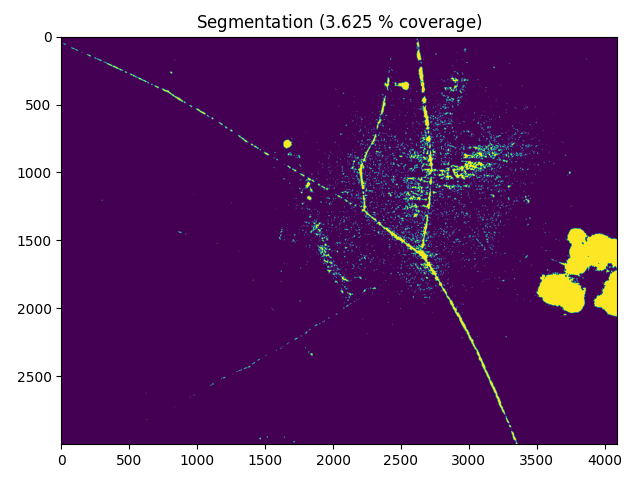

In [4]:

### This is where the video folder in question is supplied. If there is an excel file one level higher, 
### it will pull the relevant parameters from that.

img_address = 'F:/AMOLF_Data/20221109_Plate462/20221109_Plate462_07/'

### Logging     means that you will see print messages documenting the progress.
### vid_type    is either 'BRIGHT' or 'FLUO' for brightfield and fluorescence microscopy respectively. 
###                 Will be overruled if excel file is present
### fps         is the frames per second of the video
###                 Will be overruled if excel file is present
### binning     is whether the video was imaged at full resolution, or half resolution
###                 Will be overruled if excel file is present
### filter_step is not a known value
### seg_thresh  is the percentage coverage that the segmentation must achieve
### show_seg    if true will plot the segmentation image

test_video = Kymo_video_analysis(img_address, logging=True, vid_type=None, 
                                 fps=None, binning=None, filter_step=80,
                                seg_thresh=10, show_seg=True)
edge_list = test_video.edge_objects

If the segmentation is satisfactory, you can proceed with plotting the edges that will be analyzed. 


 To work with individual edges, here is a list of their indices:
edge 0, (8035, 7351)


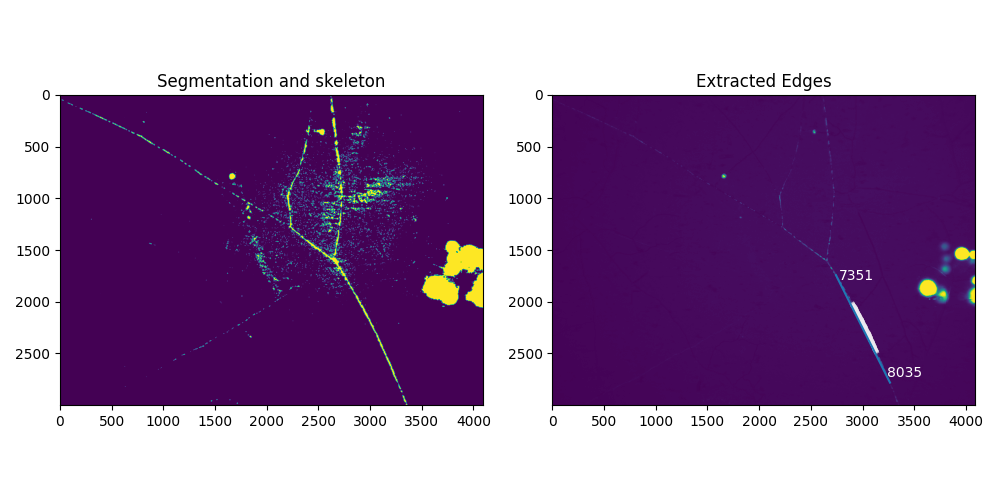

Saved the extracted edges


In [13]:
### The print statement will give you the edge indices such that you can select which edges to analyze.
print('\n To work with individual edges, here is a list of their indices:')
for i, edge in enumerate(edge_list):
    print('edge {}, {}'.format(i, edge.edge_name))
    
### Target length here determines the *width* of the analysis box. 
### Too shallow, and you won't capture the entire hypha, too big and the analysis is plagued with background.
target_length = int(5.0*test_video.magnification)

test_video.plot_extraction_img(target_length=target_length, save_img=True, step=50)
edges_total = test_video.edge_objects

## Below function will make an mp4 from the tiff files, can take a while, if you prefer to skip, that's fine.

In [10]:
test_video.makeVideo()

2023-05-03 15:20:41,266-[WARNING]- imageio_ffmpeg:562 -> IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1022, 750) to (1024, 752) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


## This is where you select the edges that you want to analyze.
Bin number creates a range of how the edges will be partitioned along their length.

In [14]:
edge_seq = [0]
# bin_nrs = np.arange(1,5)

In [ ]:
bin_nr = 1
edge_objs  = [edges_total[i] for i in edge_seq]
img_seq    = np.arange(len(edge_objs[0].video_analysis.selection_file))
kymos = []

### Exponential fit is performed to adjust for photobleaching
# exp_fit    = test_video.fit_backgr(img_seq, plots=True)

### A video and single frame will be made of each edge to get a closer look

### Analysis consists of extracting a kymograph, doing fourier filtering, then extracting speeds, then transport.
### plots in each function turn on plt plots.
# for bin_nr in bin_nrs:    
for edge in edge_objs:
    edge_pic   = edge.view_edge(img_frame=40, step=150 ,save_im=True, target_length = target_length)
    edge_video = edge.view_edge(img_frame = img_seq, step=150, save_im=True, quality = 6, target_length=target_length)
    space_res = edge.video_analysis.space_pixel_size
    time_res = edge.video_analysis.time_pixel_size
    video_kymos = edge.extract_multi_kymo(bin_nr, target_length=target_length, kymo_adj=False)
    kymos.append(video_kymos)
    imshow_extent = [0, edge.video_analysis.space_pixel_size * edge.kymos[0].shape[1],
                                  edge.video_analysis.time_pixel_size * edge.kymos[0].shape[0], 0]
    kymos_lefts, kymos_rights = edge.fourier_kymo(bin_nr, save_im=True, save_array=True)
    speeds, times = edge.test_GST(15, w_start=3, C_thresh=0.95, C_thresh_falloff = 0.001, blur_size = 5, preblur=True, speed_thresh=50, plots=False)    
    net_trans = edge.extract_transport(noise_thresh=0.15, plots=False, save_im=True, save_flux_array=True, margin=5)    

    fig, ax = plt.subplots(2, figsize=(8,8*1.7))
    ax[0].imshow(video_kymos[0], extent=imshow_extent, aspect='auto')
    ax[1].plot(times[0], np.sum(net_trans, axis=1) / video_kymos[0].shape[1])
    fig.tight_layout()


Saved an image of the edge
2023-05-03 16:56:23,762-[WARNING]- imageio_ffmpeg:562 -> IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (20, 484) to (32, 496) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


  0%|          | 0/1 [00:00<?, ?it/s]

## Experiment zone!!!


100%|██████████| 2/2 [00:01<00:00,  1.41it/s]


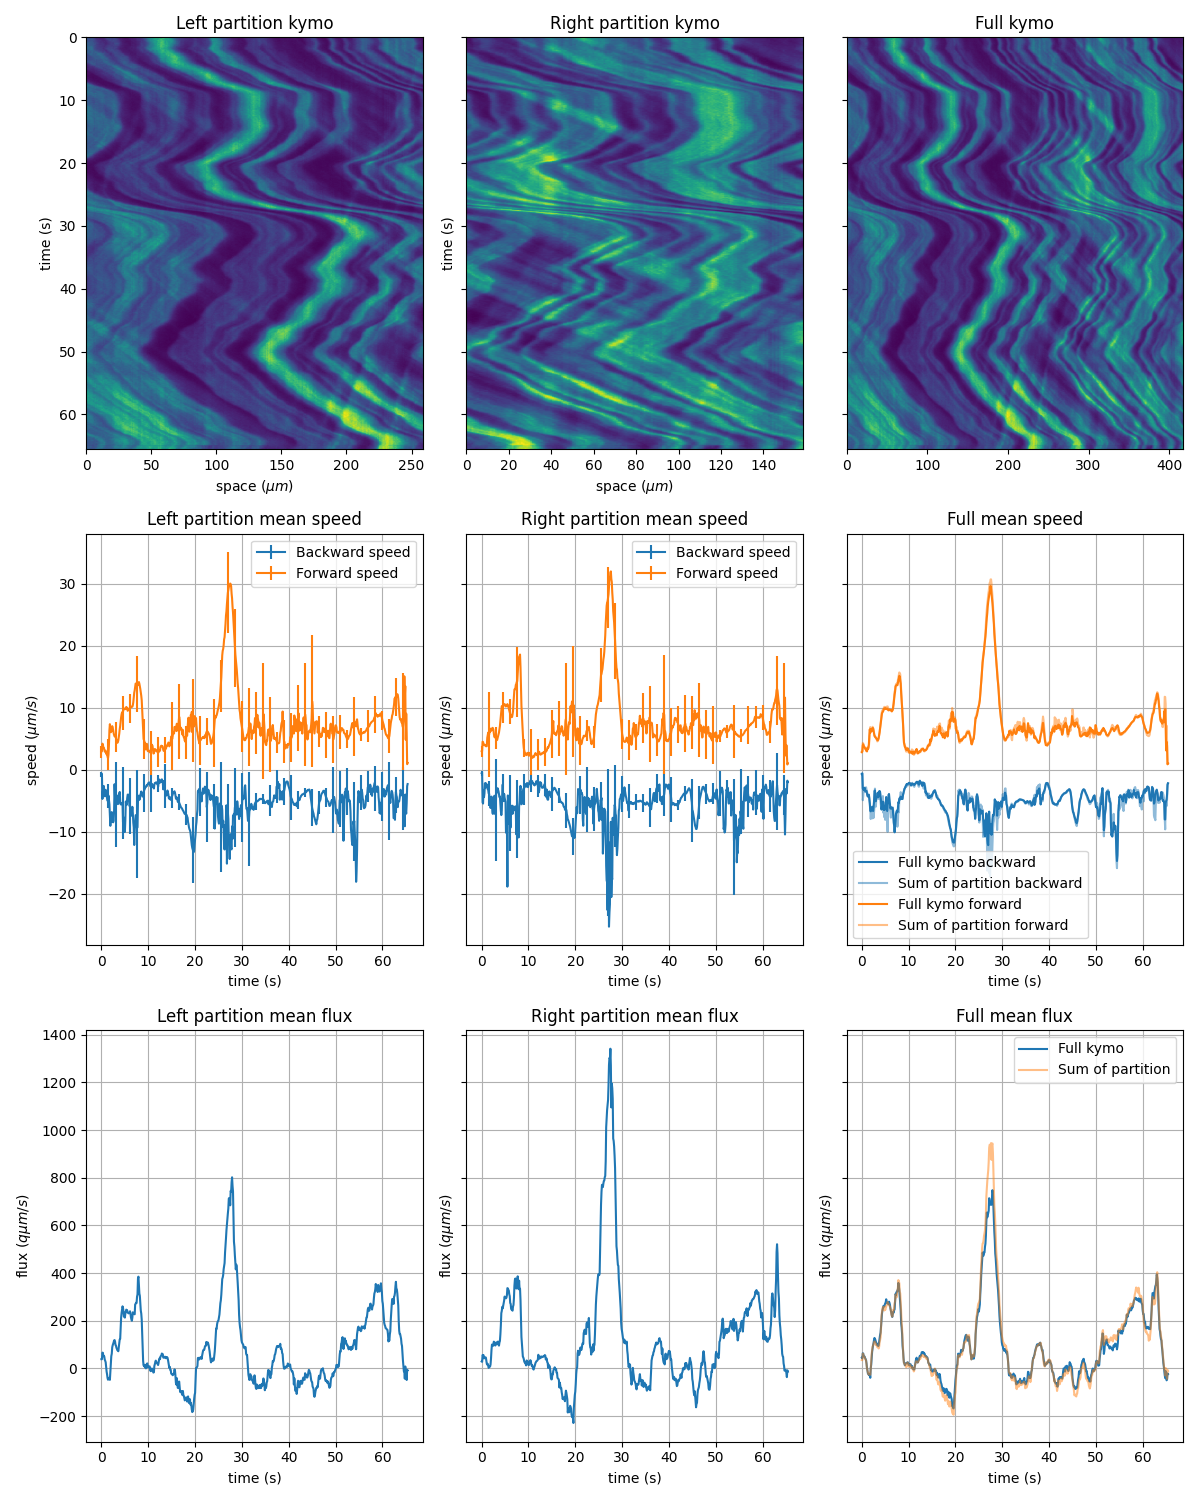

In [18]:


total_len = video_kymos[0].shape[1]
split_index = 300
split_invers = total_len - split_index

split_kymo = [video_kymos[0].T[:split_index].T, video_kymos[0].T[split_index:].T]

kymo_edge_list = [Kymo_edge_analysis(kymo=kymo) for kymo in split_kymo]

fig, ax = plt.subplots(3, 3, figsize=(12,15), sharey='row')
net_speeds = []
net_net_trans = []

for i, kymo_anal in enumerate(tqdm(kymo_edge_list)):
    title = f"({i}, {i+1})"
    
    imshow_extent = [0, space_res * kymo_anal.kymo.shape[1],
                time_res * kymo_anal.kymo.shape[0], 0]
    kymo_anal.space_pixel_size = space_res
    kymo_anal.time_pixel_size = time_res
    
    forw_thresh, back_thresh = kymo_anal.fourier_kymo(1, test_plots=False)
    
    speeds_split, times = kymo_anal.test_GST(15, w_start=3, C_thresh=0.95, C_thresh_falloff = 0.001, blur_size = 3, preblur=True, speed_thresh=50, plots=False)
    net_trans_split = kymo_anal.extract_transport(noise_thresh=0.15, plots=False, save_im=False, save_flux_array=False, save_filters=False, margin=5)    
    
    net_net_trans.append(net_trans_split)
    net_speeds.append(speeds_split)
    ax[0][i].imshow(kymo_anal.kymo, extent=imshow_extent, aspect='auto')
    ax[0][i].set_title(f"{['Left','Right'][i]} partition kymo")
    ax[0][i].set_xlabel("space ($\mu m$)")
    ax[0][i].set_ylabel("time (s)")

    ax[1][i].errorbar(times[0], np.nanmean(speeds_split[0][0], axis=1), np.nanstd(speeds_split[0][0], axis=1), label='Backward speed', errorevery=15)
    ax[1][i].errorbar(times[0], np.nanmean(speeds_split[0][1], axis=1), np.nanstd(speeds_split[0][1], axis=1), label= 'Forward speed', errorevery=15)
    ax[1][i].set_title(f"{['Left','Right'][i]} partition mean speed")
    ax[1][i].set_xlabel("time (s)")
    ax[1][i].set_ylabel("speed ($\mu m/s$)")
    ax[1][i].legend()
    ax[1][i].grid(True)


    ax[2][i].plot(times[0], np.nanmean(net_trans_split, axis=1))        
    ax[2][i].set_title(f"{['Left','Right'][i]} partition mean flux")
    ax[2][i].set_xlabel("time (s)")
    ax[2][i].set_ylabel("flux ($q \mu m / s$)")
    ax[2][i].grid(True)




# net_speeds = np.array(speeds)
speed_mean = [np.nanmean(speed[0][0], axis=1) for speed in net_speeds]

imshow_extent = [0, space_res * video_kymos[0].shape[1],
            time_res * video_kymos[0].shape[0], 0]

ax[0][2].imshow(video_kymos[0], extent=imshow_extent, aspect='auto')
ax[0][2].set_title("Full kymo")
ax[1][2].plot(times[0], np.nanmean(speeds[0][0], axis=1), c='tab:blue', label='Full kymo backward')
ax[1][2].plot(times[0], np.sum([np.nanmean(speed[0][0], axis=1)*([split_index/total_len, split_invers/total_len][i]) for i, speed in enumerate(net_speeds)], axis=0), alpha=0.5, c='tab:blue', label='Sum of partition backward')

ax[1][2].plot(times[0], np.nanmean(speeds[0][1], axis=1), c='tab:orange', label='Full kymo forward')
ax[1][2].plot(times[0], np.sum([np.nanmean(speed[0][1], axis=1)*([split_index/total_len, split_invers/total_len][i]) for i, speed in enumerate(net_speeds)], axis=0), alpha=0.5, c='tab:orange', label='Sum of partition forward')


ax[1][2].set_title(f"Full mean speed")
ax[1][2].set_xlabel("time (s)")
ax[1][2].set_ylabel("speed ($\mu m/s$)")
ax[1][2].legend()
ax[1][2].grid(True)
ax[2][2].plot(times[0], np.nanmean(net_trans, axis=1), label='Full kymo')
ax[2][2].plot(times[0], np.sum([np.nanmean(net_net_trans_t, axis=1)*([split_index/total_len, split_invers/total_len][i]) for i, net_net_trans_t in enumerate(net_net_trans)], axis=0), alpha=0.5, label='Sum of partition')
ax[2][2].set_title(f"Full mean flux")
ax[2][2].set_xlabel("time (s)")
ax[2][2].set_ylabel("flux ($q \mu m / s$)")
ax[2][2].legend()
ax[2][2].grid(True)

fig.tight_layout()




In [9]:

# fig, ax = plt.subplots(1, bins)
# for i in range(1, 30):
#     for j in range(bins):
#         corr = signal.correlate(kymo[1][0], kymo[1][bins_space[j]:bins_space[j+1]][i])
#         corr /= np.max(corr)
#         lags = signal.correlation_lags(len(kymo[0][0]), len(kymo[0][bins_space[j]:bins_space[j+1]][i]))
#         ax[j].plot(lags, corr)
# plt.show()

In [10]:
# fig, ax = plt.subplots(len(edge_objs), bin_nr, figsize=(6, 12), sharey='row')
# count = 0

# bin_space = np.linspace(0,1, bin_nr+1)

# for i in range(len(edge_objs)):
#     for j in range(bin_nr):
#         if len(edge_objs) > 1:
#             if bin_nr > 1:
#                 ax[i][j].imshow(kymo[i][j])
#                 ax[i][j].set_title(f"Kymo [{bin_space[j]}-{bin_space[j+1]}] of edge {edge_objs[i].edge_name}")
#                 ax[i][j].set_xlabel("space ($x$)")
#                 ax[i][j].set_ylabel("time ($t$)")
#             elif bin_nr == 1:
#                 ax[i].imshow(kymo[i][0])
#                 ax[i].set_title(f"Kymo of edge {edge_objs[i].edge_name}")
#                 ax[i].set_xlabel("space ($x$)")
#                 ax[i].set_ylabel("time ($t$)")
                
#         else:
#             if bin_nr == 1:
#                 ax = [ax]
#             ax[j].imshow(kymo[i][j])
#             ax[j].set_title(f"Kymo [{bin_space[j]}-{bin_space[j+1]}]")
#             ax[j].set_xlabel("space ($x$)")
#             ax[j].set_ylabel("time ($t$)")

# fig.tight_layout()
# # plt.show()

In [11]:

# fig, ax = plt.subplots(1, bins)
# for i in range(1, 30):
#     for j in range(bins):
#         corr = signal.correlate(kymo[1][0], kymo[1][bins_space[j]:bins_space[j+1]][i])
#         corr /= np.max(corr)
#         lags = signal.correlation_lags(len(kymo[0][0]), len(kymo[0][bins_space[j]:bins_space[j+1]][i]))
#         ax[j].plot(lags, corr)
# plt.show()

In [12]:
# fig, ax = plt.subplots(len(edge_objs), bin_nr, figsize=(6, 12), sharey='row')
# count = 0

# bin_space = np.linspace(0,1, bin_nr+1)

# for i in range(len(edge_objs)):
#     for j in range(bin_nr):
#         if len(edge_objs) > 1:
#             if bin_nr > 1:
#                 ax[i][j].imshow(kymo[i][j])
#                 ax[i][j].set_title(f"Kymo [{bin_space[j]}-{bin_space[j+1]}] of edge {edge_objs[i].edge_name}")
#                 ax[i][j].set_xlabel("space ($x$)")
#                 ax[i][j].set_ylabel("time ($t$)")
#             elif bin_nr == 1:
#                 ax[i].imshow(kymo[i][0])
#                 ax[i].set_title(f"Kymo of edge {edge_objs[i].edge_name}")
#                 ax[i].set_xlabel("space ($x$)")
#                 ax[i].set_ylabel("time ($t$)")
                
#         else:
#             if bin_nr == 1:
#                 ax = [ax]
#             ax[j].imshow(kymo[i][j])
#             ax[j].set_title(f"Kymo [{bin_space[j]}-{bin_space[j+1]}]")
#             ax[j].set_xlabel("space ($x$)")
#             ax[j].set_ylabel("time ($t$)")

# fig.tight_layout()
# # plt.show()